In [1]:
from flash_ansr.models import FlashANSRTransformer
from flash_ansr import get_path, FlashANSRDataset

from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class ComplexityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flash_ansr_transformer = FlashANSRTransformer.from_config(get_path('configs', 'v6.0', 'nsr.yaml'))
        del self.flash_ansr_transformer.decoder
        self.head = torch.nn.LazyLinear(1)

    def forward(self, x):
        pre_encodings = self.flash_ansr_transformer.pre_encoder(x)
        memory = self.flash_ansr_transformer.encoder(pre_encodings)
        return self.head(memory.reshape(memory.shape[0], -1))

In [3]:
model = ComplexityClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

dataset_train = FlashANSRDataset.from_config(get_path('configs', 'v6.0', 'dataset_train.yaml'))
dataset_val = FlashANSRDataset.from_config(get_path('configs', 'v6.0', 'dataset_val.yaml'))
batch_size = 128

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 16273.98it/s]


In [4]:
history = defaultdict(list)

alpha = 0.99
running_loss = None
steps = 10_000
val_every_steps = 100
last_val_loss = None

pbar = tqdm(total=steps)

for b, batch in enumerate(dataset_train.iterate(steps=steps, batch_size=batch_size)):
    optimizer.zero_grad()
    input_ids, x_tensor, y_tensor, labels, constants = FlashANSRDataset.collate_batch(batch, device)
    complexities = torch.sum((labels != 0) & (labels != 2), dim=1).float().unsqueeze(-1)

    # Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
    pad_length = model.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
    if pad_length > 0:
        x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)

    # Concatenate x and y tensors as input to the set transformer
    data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

    # Forward pass
    output = model(data_tensor)
    loss = nn.functional.mse_loss(output, complexities)

    # Backward pass
    loss.backward()
    optimizer.step()

    history['loss'].append(loss.item())
    history['_step'].append(b)

    if running_loss is None:
        running_loss = loss.item()
    else:
        running_loss = alpha * running_loss + (1 - alpha) * loss.item()

    if b % val_every_steps == 0:
        val_losses = []
        with torch.no_grad():
            for val_batch in dataset_val.iterate(steps=10, batch_size=batch_size):
                input_ids, x_tensor, y_tensor, labels, constants = FlashANSRDataset.collate_batch(val_batch, device)
                complexities = torch.sum((labels != 0) & (labels != 2), dim=1).float().unsqueeze(-1)
                pad_length = model.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
                if pad_length > 0:
                    x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
                data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
                output = model(data_tensor)
                val_losses.append(nn.functional.mse_loss(output, complexities).item())
        history['val_loss'].append(np.mean(val_losses))
        last_val_loss = history['val_loss'][-1]
    else:
        history['val_loss'].append(np.nan)

    pbar.set_postfix_str(f"Loss: {running_loss:.4f}, Val Loss: {last_val_loss:.4f}")
    pbar.update()

100%|██████████| 10000/10000 [41:15<00:00,  4.09it/s, Loss: 9.6509, Val Loss: 9.5036]   

In [6]:
def smooth_w_boundaries(x, window_len=101):
    if window_len % 2 == 0:
        window_len += 1

    if window_len < 3:
        return x

    kernel = np.hanning(window_len)
    kernel /= kernel.sum()

    # Convolve the middle part with valid mode
    x_convolved_middle = np.convolve(x, kernel, mode='valid')

    # Convolve the left and right boundaries such that only overlapping part of the kernel is used
    half_window = window_len // 2
    x_convolved_left = np.empty(2 * half_window - 1)
    x_convolved_right = np.empty(2 * half_window - 1)
    for i in range(1, 2 * half_window):
        x_convolved_left[i - 1] = x[:i] @ kernel[-i:] / kernel[-i:].sum()
        x_convolved_right[i - 1] = x[- 2 * half_window + i:] @ kernel[:2 * half_window - i] / kernel[:2 * half_window - i].sum()

    # Concatenate the left, middle and
    x_convolved = np.concatenate((x_convolved_left[half_window - 1:], x_convolved_middle, x_convolved_right[:half_window]))

    return x_convolved

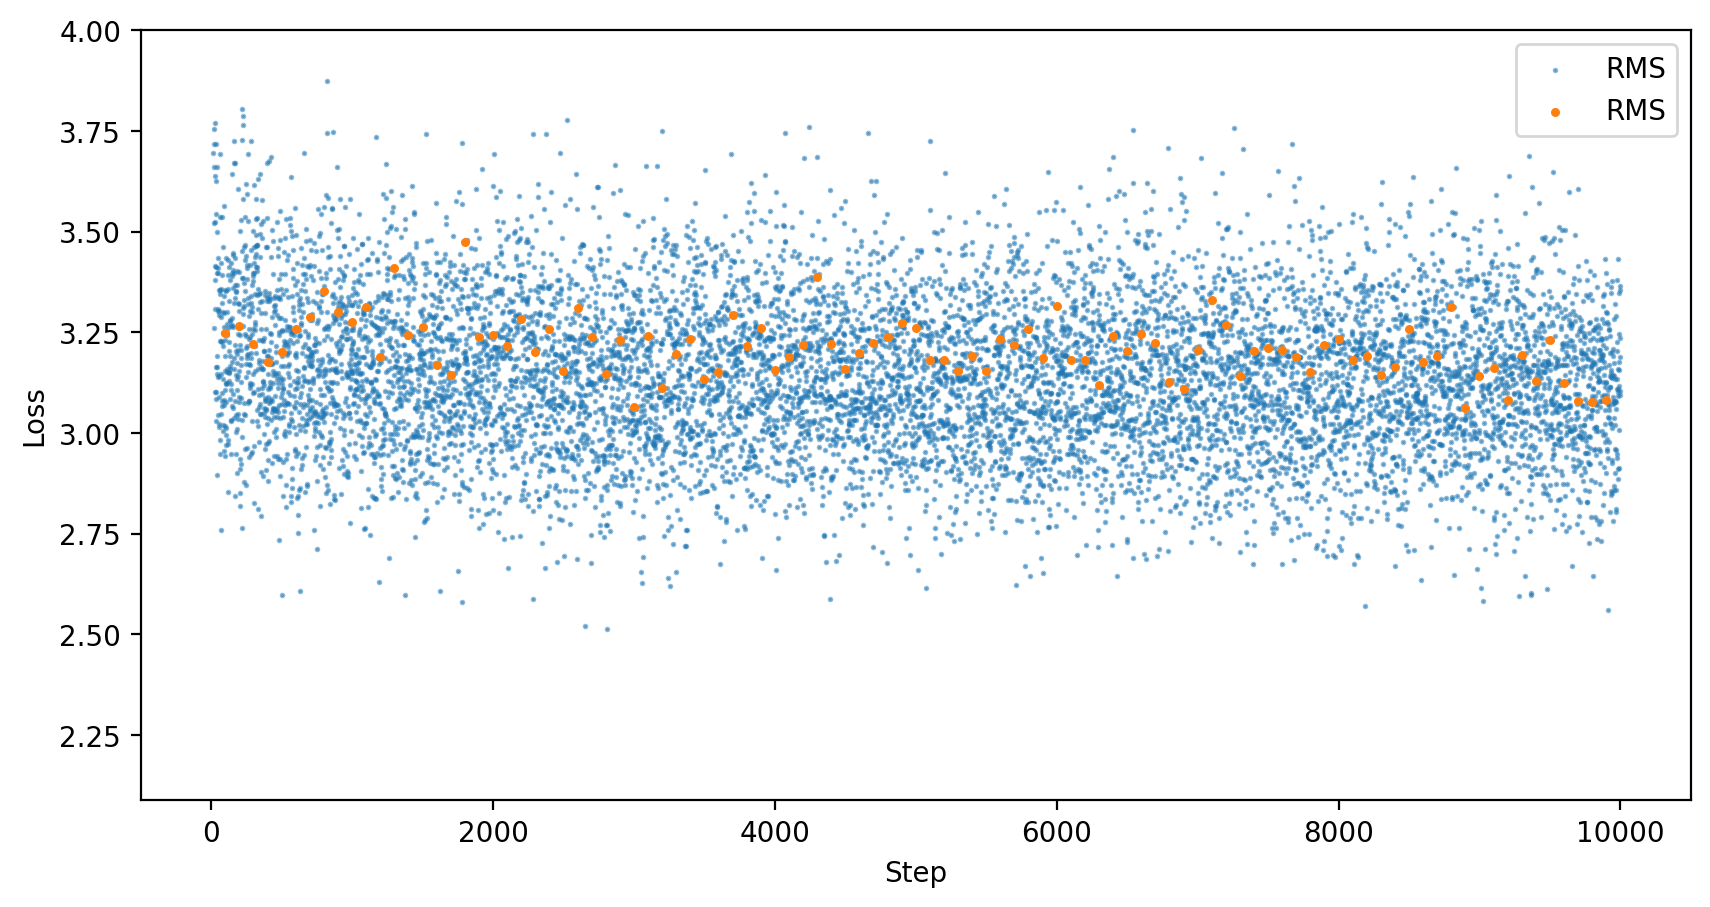

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
w = 101

# ax.plot(smooth_w_boundaries(history['_step'], w), smooth_w_boundaries(np.sqrt(history['loss']), w), label='RMS')
# valid_mask = np.isfinite(history['val_loss'])
# ax.plot(smooth_w_boundaries(np.array(history['_step'])[valid_mask], 5), smooth_w_boundaries(np.sqrt(np.array(history['val_loss'])[valid_mask]), 5), label='RMS')
ax.scatter(history['_step'], np.sqrt(history['loss']), label='RMS', s=1, alpha=0.5)
# ax.hist2d(history['_step'], np.sqrt(history['loss']), label='RMS', bins=100)
valid_mask = np.isfinite(history['val_loss'])
ax.scatter(np.array(history['_step'])[valid_mask], np.sqrt(np.array(history['val_loss'])[valid_mask]), label='RMS', s=5)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1, None)
ax.set_ylim(None, 4)
ax.legend()